In [3]:
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from os import listdir
import time
import math
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing import image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

drive_path = "/content/drive/MyDrive/Brain/BraTS2019"
shutil.copytree(path, drive_path)

print("Dataset copied to:", drive_path)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryanfelix/brats-2019-traintestvalid")

print("/content/drive/MyDrive/Brain", path)

In [25]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [36]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)
train = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Brain/BraTS2019/dataset/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
test = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Brain/BraTS2019/dataset/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
validation = val_datagen.flow_from_directory(
        '/content/drive/MyDrive/Brain/BraTS2019/dataset/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 2800 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Found 200 images belonging to 2 classes.


In [53]:
print(train.class_indices)
print(test.class_indices)
print(validation.class_indices)

{'no': 0, 'yes': 1}
{}
{'no': 0, 'yes': 1}


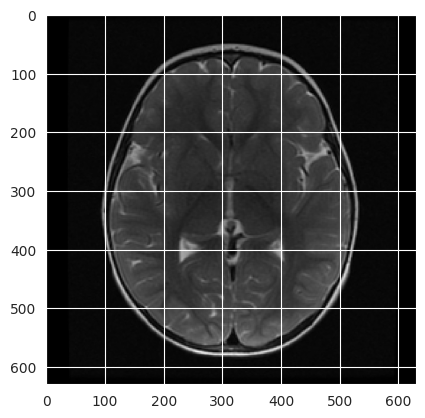

In [54]:
plt.imshow(plt.imread("/content/drive/MyDrive/Brain/BraTS2019/dataset/test/N1.jpeg"))

In [55]:
IMG_SIZE = (224,224)
import imutils
img = cv2.imread('/content/drive/MyDrive/Brain/BraTS2019/dataset/test/Y1.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

Text(0.5, 1.0, 'Step 1. Get the original image')

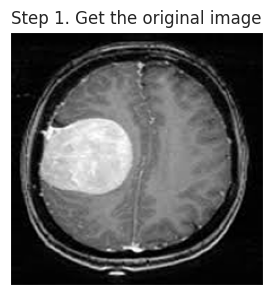

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Get the original image')


Text(0.5, 1.0, 'biggest contour')

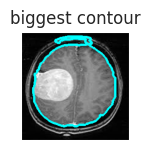

In [57]:
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('biggest contour')


Text(0.5, 1.0, 'extreme points')

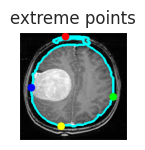

In [58]:
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('extreme points')


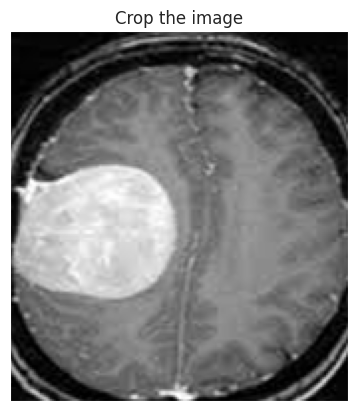

In [59]:
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Crop the image')
plt.show()

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
base_model = MobileNet(input_shape=(224, 224, 3),
    include_top=False)

In [38]:
base_model.trainable = False # We freeze the training of the convolutions
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [60]:
# Flatten the output layer to 1 dimension
cnn = Flatten()(base_model.output)
cnn = Dense(units=1024, activation ="relu")(cnn)
# Add
cnn = Dropout(0.2)(cnn)
# Add a final sigmoid layer for classification
cnn = Dense(units = 1, activation = "sigmoid")(cnn)
cnn = Model( base_model.input, cnn)

In [40]:
cnn.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 54,611,137 (208.32 MB)

 Trainable params: 51,382,273 (196.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

<font color="green">
4.Train the new layers on your dataset.

In [41]:
cnn.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [42]:
es = EarlyStopping(monitor='val_accuracy',min_delta= 0.01 ,  patience= 2, verbose= 2, mode='auto')
mc = ModelCheckpoint(filepath="content/best_modelwithtransferlearning.h5",monitor='val_accuracy',save_best_only = True )
cnn.fit(x=train,validation_data=validation,epochs=5,callbacks = [mc,es], steps_per_epoch=50)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7189 - loss: 4.3295

50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 743ms/step - accuracy: 0.7208 - loss: 4.2766 - val_accuracy: 0.8550 - val_loss: 0.6272
Epoch 2/5
38/50 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - accuracy: 0.8803 - loss: 0.3510

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 0.8858 - loss: 0.3354 - val_accuracy: 0.9300 - val_loss: 0.2325
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 554ms/step - accuracy: 0.9241 - loss: 0.2592 - val_accuracy: 0.9050 - val_loss: 0.4067
Epoch 4/5
38/50 ━━━━━━━━━━━━━━━━━━━━ 6s 504ms/step - accuracy: 0.9405 - loss: 0.2038

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - accuracy: 0.9423 - loss: 0.1922 - val_accuracy: 0.9500 - val_loss: 0.1831
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 550ms/step - accuracy: 0.9617 - loss: 0.1303 - val_accuracy: 0.9200 - val_loss: 0.3326


In [43]:
print(cnn.evaluate(validation))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9208 - loss: 0.3527
[0.33256709575653076, 0.9200000166893005]


In [44]:
model_best = load_model("/content/content/best_modelwithtransferlearning.h5")

In [45]:
model_best.evaluate(validation)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9359 - loss: 0.2018


[0.18314136564731598, 0.949999988079071]

In [46]:
validation.class_indices

{'no': 0, 'yes': 1}

In [47]:
def predictor(path):
    img = image.load_img(path, target_size=(224,224),  )
    i = image.img_to_array(img)/255
    input_arr = np.array([i])
    input_arr.shape
    pred = model.predict(input_arr)[0][0]
    if pred > 0.5:
        print("The MRI image is of BRAIN TUMOR")
    else:
        print("The MRI image is of HEALTHY BRAIN WITHOUT TUMOR")


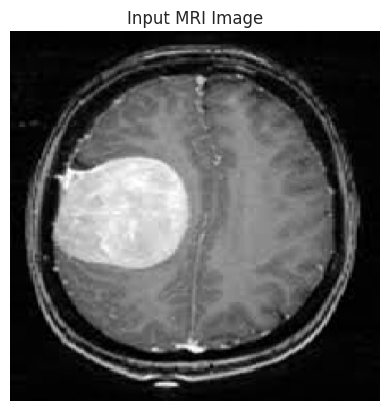

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🧠 The MRI image is of **BRAIN TUMOR**


In [52]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model (change the filename to match yours)
model = load_model("/content/content/best_modelwithtransferlearning.h5")

# Prediction function
def predictor(path):
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.title("Input MRI Image")
    plt.axis("off")
    plt.show()

    img_array = image.img_to_array(img) / 255.0
    input_arr = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)

    pred = model.predict(input_arr)[0][0]

    if pred > 0.5:
        print("🧠 The MRI image is of **BRAIN TUMOR**")
    else:
        print("✅ The MRI image is of **HEALTHY BRAIN WITHOUT TUMOR**")

# Example usage: Update with your actual image path
predictor("/content/drive/MyDrive/Brain/BraTS2019/dataset/test/Y1.jpg")


In [61]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv_pw_13_relu", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [62]:
def predictor_with_xai(image_path):
    img = image.load_img(image_path, target_size=(224,224))
    i = image.img_to_array(img)/255.0
    input_arr = np.expand_dims(i, axis=0)

    prediction = model.predict(input_arr)[0][0]

    if prediction > 0.5:
        print("🧠 The MRI image is of BRAIN TUMOR")
    else:
        print("✅ The MRI image is of HEALTHY BRAIN WITHOUT TUMOR")

    # Generate heatmap
    heatmap = make_gradcam_heatmap(input_arr, model)

    # Resize heatmap to match image
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)

    # Apply heatmap to original image
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(i * 255), 0.6, heatmap_color, 0.4, 0)

    # Show the Grad-CAM
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
🧠 The MRI image is of BRAIN TUMOR


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


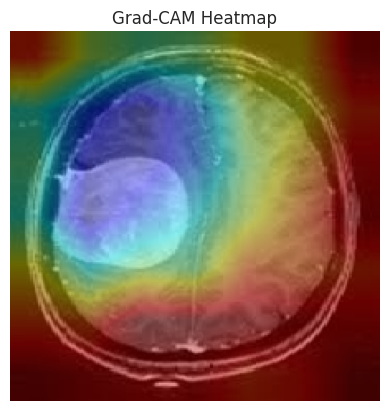

In [63]:
predictor_with_xai("/content/drive/MyDrive/Brain/BraTS2019/dataset/test/Y1.jpg")
